# TODO
1. Plot the Learning Curve
2. Make everything fancy

In [ ]:
!pip install scikeras

In [34]:
import keras
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Importing model and preparing Inputs

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

num_classes = 6

In [ ]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/NelloArchives/DL/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [4]:
target_folder = "temp"
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

## Brief Analysis

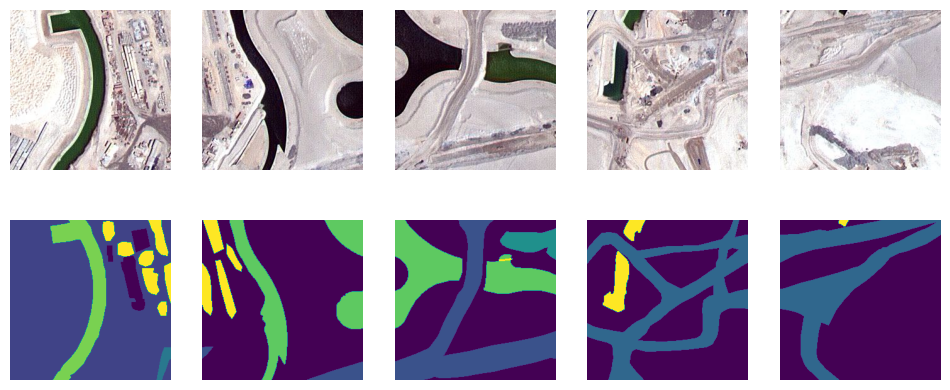

In [5]:
def plot_example(imgs, masks, num_images=5):
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(masks[i])
        plt.axis('off')
    plt.show()

# Example usage
plot_example(imgs, masks, num_images=5)

In [6]:
print(imgs.shape, masks.shape)

(1305, 256, 256, 3) (1305, 256, 256, 1)


## Splitting The Data

In [7]:
imgs_train, imgs_test, masks_train, masks_test = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)

print("Training images shape:", imgs_train.shape)
print("Testing images shape:", imgs_test.shape)
print("Training masks shape:", masks_train.shape)
print("Testing masks shape:", masks_test.shape)

Training images shape: (1044, 256, 256, 3)
Testing images shape: (261, 256, 256, 3)
Training masks shape: (1044, 256, 256, 1)
Testing masks shape: (261, 256, 256, 1)


# Defining the model

In [8]:
class KerasImageSegmentationModel(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 lr = 0.001,
                 filters = [8, 15, 21, 30],
                 filtersize = 3,
                 stride = 2,
                 epochs = 10,
                 batch_size = 8):

        self.lr = lr
        self.filters = filters
        self.filtersize = filtersize
        self.stride = stride
        self.epochs = epochs
        self.classes_ = np.arange(6)
        self.batch_size = batch_size
        self.model = self.build_model(lr, filters, filtersize, stride)

    def build_model(self, lr, filters, filtersize, stride):

        n_layers = len(filters)
        inputs = Input(shape = (256,256,3))

        s = Lambda(lambda x: x / 255) (inputs) # Preprocessing

        # Encoder
        conv_layers = []
        x = s
        for i in range(n_layers):
            x = Conv2D(filters[i], (filtersize, filtersize),  kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            conv_layers.append(x)
            if i < n_layers - 1:
                x = MaxPooling2D((stride, stride))(x)

        # Decoder
        for i in range(n_layers - 2, -1, -1):
            x = Conv2DTranspose(filters[i], (stride, stride), strides=(stride,stride), padding='same')(x)
            x = concatenate([x, conv_layers[i]])
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)

        x = Conv2D(1, filtersize, padding='same')(x)
        x = LeakyReLU(negative_slope=0.1)(x)
        outputs = Conv2D(6, 1, padding='valid', activation='softmax')(x)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"]
        )

        return model

    def fit(self, X, y, validation_data=None, callbacks=None):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=2, validation_data=validation_data, callbacks=callbacks)
        return self

    def predict(self, X):
        return self.model.predict(X)

# HyperParameter Tuning

In [9]:
def f1_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1)

    # Flatten the arrays to shape (batch_size * height * width,)
    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    f1 = f1_score(y_true_flat, y_pred_flat, average="macro")

    return f1


def accuracy_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1) #from probabilities to integers

    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    acc = accuracy_score(y_true_flat, y_pred_flat)

    return acc

f1_scorer = make_scorer(f1_forImages, greater_is_better=True)
acc_scorer = make_scorer(accuracy_forImages, greater_is_better=True)

In [10]:
model = KerasImageSegmentationModel()

filters = [[8, 12, 16, 20, 24], #similar number of parameters is maintained across these configurations
           [8, 15, 21, 30]]
filtersize = [5,7]
stride = [2] # due to RAM limitations I had to remove the hypertuning on stride, also, higher strides were lowering performances
lr = [0.001, 0.0001]
batchsizes = [16, 32]

param_grid = {

    "filters": filters,
    "lr": lr,
    "filtersize": filtersize,
    "stride": stride,
    "batch_size": batchsizes
}

I0000 00:00:1721330576.075981  144248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721330576.244162  144248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721330576.244207  144248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721330576.247210  144248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721330576.247303  144248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [11]:
gs = GridSearchCV(estimator=model, param_grid=param_grid,
                  n_jobs=1,
                  scoring=f1_scorer,
                  error_score="raise",
                  cv=2,
                  verbose=3)


# grid_result = gs.fit(imgs_train, masks_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Epoch 1/10
33/33 - 33s - 1s/step - accuracy: 0.2810 - loss: 1.6110
Epoch 2/10
33/33 - 2s - 64ms/step - accuracy: 0.5738 - loss: 1.3476
Epoch 3/10
33/33 - 2s - 64ms/step - accuracy: 0.5755 - loss: 1.2421
Epoch 4/10
33/33 - 3s - 76ms/step - accuracy: 0.5807 - loss: 1.1803
Epoch 5/10
33/33 - 2s - 63ms/step - accuracy: 0.5844 - loss: 1.1364
Epoch 6/10
33/33 - 2s - 65ms/step - accuracy: 0.5885 - loss: 1.0997
Epoch 7/10
33/33 - 2s - 64ms/step - accuracy: 0.5982 - loss: 1.0704
Epoch 8/10
33/33 - 2s - 65ms/step - accuracy: 0.6061 - loss: 1.0270
Epoch 9/10
33/33 - 2s - 66ms/step - accuracy: 0.6133 - loss: 0.9857
Epoch 10/10
33/33 - 3s - 76ms/step - accuracy: 0.6282 - loss: 0.9585
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step
[CV 1/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=5, lr=0.001, stride=2;, score=0.266 total time= 1.4min
Epoch 1/10
33/33 - 13s - 395ms/step - accuracy: 0.4951 - loss: 1.6779
Epoch 2/10
33/33 - 4s - 1

In [12]:
# print("Best: %f using %s" % (grid_result.best_score_,
#                              grid_result.best_params_))

# means = grid_result.cv_results_['mean_test_score']
# params = grid_result.cv_results_['params']

# params = gs.best_params_
# joblib_file = 'best_params.joblib'
# joblib.dump(params, joblib_file)
# results = grid_result.cv_results_
# joblib_file = "gsresults"
# joblib.dump(results, joblib_file)

Best: 0.303668 using {'batch_size': 16, 'filters': [8, 15, 21, 30], 'filtersize': 5, 'lr': 0.0001, 'stride': 2}


['best_params.joblib']

In [11]:
gs_results = joblib.load("gsresults.joblib")
best_params = joblib.load("best_params.joblib")

In [46]:
imgs_train_new, imgs_val, masks_train_new, masks_val = train_test_split(
    imgs_train, masks_train, test_size=0.2, random_state=42
)

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=15,          # Number of epochs with no improvement after which training will be stopped
                               verbose=1,           # Verbosity mode
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity


best_model = KerasImageSegmentationModel(**best_params, epochs= 250)
# best_model.fit(imgs_train_new, masks_train_new, validation_data=(imgs_val, masks_val), callbacks=[early_stopping])

Epoch 1/250
53/53 - 13s - 241ms/step - accuracy: 0.1307 - loss: 1.7721 - val_accuracy: 0.1885 - val_loss: 1.7598
Epoch 2/250
53/53 - 4s - 75ms/step - accuracy: 0.1610 - loss: 1.7497 - val_accuracy: 0.1423 - val_loss: 1.7368
Epoch 3/250
53/53 - 4s - 76ms/step - accuracy: 0.1403 - loss: 1.7296 - val_accuracy: 0.1418 - val_loss: 1.7238
Epoch 4/250
53/53 - 4s - 76ms/step - accuracy: 0.1418 - loss: 1.7180 - val_accuracy: 0.1423 - val_loss: 1.7128
Epoch 5/250
53/53 - 4s - 75ms/step - accuracy: 0.1458 - loss: 1.7071 - val_accuracy: 0.1430 - val_loss: 1.7049
Epoch 6/250
53/53 - 4s - 75ms/step - accuracy: 0.1537 - loss: 1.6994 - val_accuracy: 0.1478 - val_loss: 1.6933
Epoch 7/250
53/53 - 4s - 76ms/step - accuracy: 0.1619 - loss: 1.6881 - val_accuracy: 0.1505 - val_loss: 1.6863
Epoch 8/250
53/53 - 4s - 76ms/step - accuracy: 0.1769 - loss: 1.6791 - val_accuracy: 0.1530 - val_loss: 1.6789
Epoch 9/250
53/53 - 4s - 76ms/step - accuracy: 0.1817 - loss: 1.6695 - val_accuracy: 0.1572 - val_loss: 1.6696

KerasImageSegmentationModel(batch_size=16, epochs=250, filtersize=5, lr=0.0001)

Best number of epochs seemed to be 180, I'll now train on both train and validation for 180 epochs

In [87]:
best_model = KerasImageSegmentationModel(**best_params, epochs= 180)
best_model.fit(imgs_train, masks_train)

Epoch 1/180
66/66 - 17s - 255ms/step - accuracy: 0.1064 - loss: 1.6947
Epoch 2/180
66/66 - 5s - 72ms/step - accuracy: 0.1129 - loss: 1.6261
Epoch 3/180
66/66 - 5s - 70ms/step - accuracy: 0.1578 - loss: 1.5921
Epoch 4/180
66/66 - 5s - 69ms/step - accuracy: 0.1682 - loss: 1.5668
Epoch 5/180
66/66 - 5s - 70ms/step - accuracy: 0.1773 - loss: 1.5371
Epoch 6/180
66/66 - 5s - 70ms/step - accuracy: 0.1807 - loss: 1.5159
Epoch 7/180
66/66 - 5s - 70ms/step - accuracy: 0.1833 - loss: 1.4962
Epoch 8/180
66/66 - 5s - 70ms/step - accuracy: 0.1842 - loss: 1.4799
Epoch 9/180
66/66 - 5s - 70ms/step - accuracy: 0.1857 - loss: 1.4660
Epoch 10/180
66/66 - 5s - 71ms/step - accuracy: 0.1881 - loss: 1.4467
Epoch 11/180
66/66 - 5s - 73ms/step - accuracy: 0.1898 - loss: 1.4293
Epoch 12/180
66/66 - 5s - 74ms/step - accuracy: 0.1916 - loss: 1.4123
Epoch 13/180
66/66 - 5s - 73ms/step - accuracy: 0.1937 - loss: 1.3952
Epoch 14/180
66/66 - 5s - 73ms/step - accuracy: 0.1961 - loss: 1.3785
Epoch 15/180
66/66 - 5s - 7

KerasImageSegmentationModel(batch_size=16, epochs=180, filtersize=5, lr=0.0001)

In [88]:
#best_model.model.save('best_model.h5')

In [12]:
best_model = load_model('best_model.h5')

In [13]:
test_preds = best_model.predict(imgs_test)

I0000 00:00:1721330601.392929  144515 service.cc:146] XLA service 0x7f44d4048550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721330601.392978  144515 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-07-18 21:23:21.442905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 21:23:21.536629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1721330605.519048  144515 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721330605.681664  144515 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

I0000 00:00:1721330607.821508  144515 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step


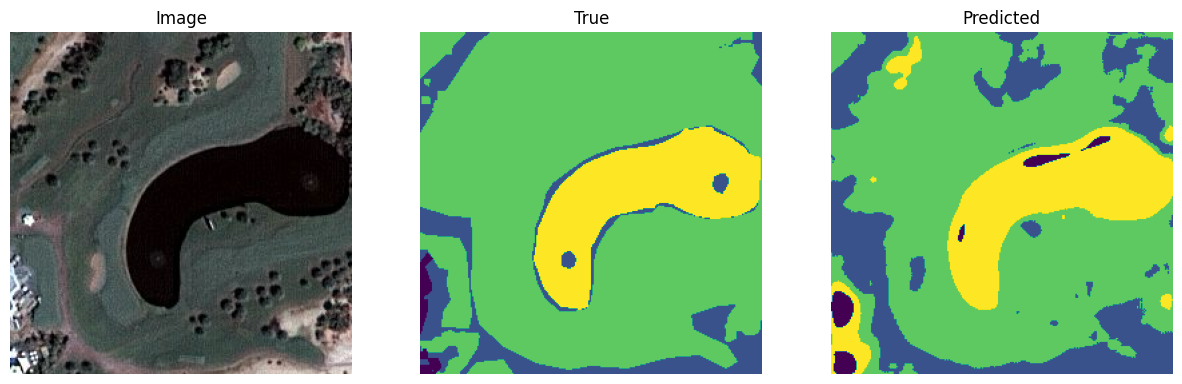

In [31]:
th_pred = np.argmax(test_preds, axis=-1)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

i = 3

axes[0].imshow(imgs_test[i])
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(masks_test[i])
axes[1].set_title("True")
axes[1].axis('off')

axes[2].imshow(th_pred[i])
axes[2].set_title("Predicted")
axes[2].axis('off')

plt.show()

# Model Evaluation

In [16]:
print(f1_forImages(masks_test,test_preds))
print(accuracy_forImages(masks_test,test_preds))

mask_pred_train = best_model.predict(imgs_train)
print(f1_forImages(masks_train,mask_pred_train))
print(accuracy_forImages(masks_train,mask_pred_train))


0.4607724710910885
0.7449923109734196
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step


2024-07-18 21:23:45.925393: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642070016 exceeds 10% of free system memory.


0.4698740956398156
0.7436723087939267


In [38]:
# train_sizes, train_scores, test_scores = learning_curve(best_model,
#                                                        X=imgs_train,
#                                                        y=masks_train,
#                                                        train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4],
#                                                        cv = 2,
#                                                        n_jobs = 1,
#                                                        scoring = f1_scorer,
#                                                        shuffle = True)

TypeError: Cannot clone object '<Functional name=functional_11, built=True>' (type <class 'keras.src.models.functional.Functional'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.